# Regression Discontinuity Analysis



Recordar el uso de regresión discontinua: Este método se usa para estimar un efecto causal en los casos en que una prueba aleatoria no es posible.


La Regresión discontinua se usa cuando algún tipo de corte determina quién entra en un grupo en lugar de otro. En lugar de analizar el efecto del predictor en el resultado para toda la población, comparamos los resultados previstos en ambos lados del corte.

Este problem set se fundamenta en el paper de Joshua Angrist and Victor Lavy (REVISARLO): "[Using Maimonides Rule' to Estimate the Effect of Class Size on Scholastic Achievement](http://qje.oxfordjournals.org/content/114/2/533.short)." En este paper los autores señalan que no es posible aleatorizar la asignación en el tamaño de la clase pero pudieron *aprovechar* una regla en las escuelas israelíes que dividía las clases en tamaños más pequeños si la inscripción era de 41 o más. 
Esto ofreció a Angrist y Lavy un experimento natural para su pregunta de investigación, ya que podríamos esperar que los grupos cercanos a 40 alumnos fueran muy similares a los de 42.


**El análisis Regresión Discontinua** utiliza observaciones lejos del *cuttoff* junto con otras más cercanas "con el objetivo de *proyectar* el efecto estimado del tratamiento en el *cuttoff*". 

**Q1)** Adicional a los supuestos del modelo de regresión lineal, menciona los pasos necesarios para validar (comprobar) que se cumplen los siguientes supuestos en el modelo de regresión discontinua de Angrist & Levy:
* A) El cuttoff es tan bueno como aleatorizar. To test this assumption, we can:
    * verify that there is no selection bias in the application of the cutoff, perhaps with the [McCrary Density test (2008)](http://eml.berkeley.edu/~jmccrary/mccrary2006_DCdensity.pdf) on both sides of the cutoff. See also Urquiola and Verhoogen (2009) "[Class-Size Caps, Sorting, and the Regression-Discontinuity Design](http://www.columbia.edu/~ev2124/research/Urquiola%26VerhoogenAER2009.pdf)," for an in-depth exploration of how to observe these biases.  
    * confirm that there is no unobserved influence (in the case of Angrist & Lavy, the authors consider a possible relationship between the socio-economic status of a region and cohort size)
* B) Supuesto: El modelo está bien especificado, inclusive al limitar las observaciones de "ancho de banda (bandwidth)" en ambos lados del corte.
    * sensitivity analyses at different bandwidths
    * sensitivity models that adopt a variety of possible functional forms

## Variables del modelo
En este análisis, examinos un dataset que incluye datos del nivel de escolaridad para:
* *size*: tamaño de los grupos de 5 año
* *intended_classsize*: Promedio destinado al tamaño de clase por cada escuela
* *observed_classize*: Promedio obserdado del tamaño de la clase por cada escuela
* *read*: Promedio de lectura obtenido

**Q2)** Carga las siguientes librerías y comenta en una línea su uso


In [4]:
import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy

# Lectura del Dataset

**Q3)** Utiliza read_stata para cargar el archivo class_size.dta que viene incluido en la carpeta de este ejercicio. Tambien se incluye en formato de SAS por si quieren probar otros tipos de archivos

In [ ]:
class_df = pd.read_stata("class_size.dta")

# Estadística descriptiva

**Q4)** Obtener media, desviación estándar, quartiles para las variables, read, size, intended_classize y observed_classize

In [30]:
print class_df.describe()

                              OVERALL SUMMARY
              read         size  intended_classize  observed_classize
count  2019.000000  2019.000000        2019.000000        2019.000000
mean     74.379171    77.741951          30.955935          29.935116
std       7.678460    38.810731           6.107924           6.545885
min      34.799999     8.000000           8.000000           8.000000
25%      69.855000    50.000000          27.000000          26.000000
50%      75.379997    72.000000          31.666666          31.000000
75%      79.839996   100.000000          35.666668          35.000000
max      93.860001   226.000000          40.000000          44.000000


# Construyendo la regresión discontinua

La variable (*csize*) se centrará alrededor del corte, y el predictor de corte (*small*) es una variable dicotómica que indica en qué lado del corte cae una observación.

**Q4)** Interpreta y comenta cada una de las funciones del siguiente código y córrelo:

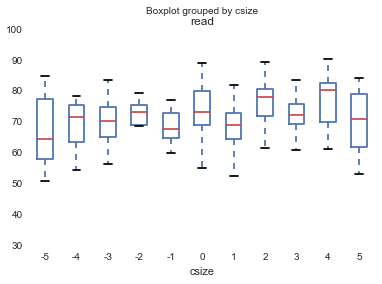

In [34]:
###Función 1
def small(size):
    if(size>=41):
        return 1
    return 0

###Función 2
def first(group):
    groups = {1: 0, 2:0,
              3: 1, 4:1}
    return groups[group]

###Función 3
class_df['small'] = class_df['size'].map(small)
class_df['csize'] = class_df['size'].map(lambda x: x-41)

###Función 4
class_df[(class_df['size']>=36) & (class_df['size']<=46)].boxplot("read", "csize")
plt.show()

**Q5)** Describe e interpreta los resultados del Boxplot. ¿Qué información relevante aporte esta visualización en el diseño del modelo?

# Regression Discontinuity

**Q6)** Definiendo la ventana de estudio. Construye dataframe que lleve por nombre window, el cual contenga únicamente tamaño de la clase menor o igual a 29 y mayor o igual a 53

In [ ]:
window = class_df[(class_df['size']>=29) & (class_df['size']<=53)]

**Q7)** Con la ventana del incisio anterior, corre la regresión discontonua con variables dependiendes csize y small. Variable independiente read.

In [ ]:
result = smf.ols(formula = "read ~ csize + small", 
                 data = window).fit()
print result.summary()

**Q8)** Utiliza la función plt.figure, plt.scatter para visualizar csize y read. Adicionalmente incorpora los las líneas de la regresión discontinua

In [17]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(window.csize,window.read, color="blue")
l=window[window.csize<0].csize.count()
plt.plot(window.csize[0:l], result.predict()[0:l], '-', color="r")
plt.plot(window.csize[l:], result.predict()[l:], '-', color="r")
plt.axvline(x=-0.5,color="black", linestyle="--")
plt.title("Regression Discontinuity: Reading Scores by Class Size Before and After the Cutoff", fontsize="18")

NameError: name 'window' is not defined

<Figure size 960x480 with 0 Axes>

**Q9** Reporta el coeficiente de la variable small. Interpreta el efecto marginal la variable small sobre el promedio de lectura.

**Q10** Los efectos del tamaño de la clase en los promedios de lectura son estadísticamente significativos?. Reporta resultados para (p<0.05). Intepreta intuitivamente la prueba de Durbin-Watson que aparece en la tabla de resultados de la regresión.